In [1]:
import numpy as np
import openpyxl.utils


import torch
import pylab as plt
from munch import munchify
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from einops import rearrange
import matplotlib.image as mpimg
from matplotlib.colors import NoNorm
import math


%matplotlib inline

In [ ]:
# This function takes in net, device, and pair of (input, label, location) and produces output
# This is used in the next cell
def drop_eval(net, x_raw, n_batch, T_samples):
    pred_list, unc_list = [], []
    for i in range(T_samples):
        out1 = net(x_raw, n_batch)
        pred = F.softmax(out1, dim=1)
        pred_list.append(torch.unsqueeze(pred, dim=0))
    pred_mean = torch.cat(pred_list, 0).mean(dim=0)
    confidence,_ = torch.max(pred_mean, dim=1)
    unc = 1. - confidence
    return pred_mean, unc

def predict(net, input_data, input_label, device, unc_method, T_samples=30, unc_thr=0.2):
    from sklearn.metrics import confusion_matrix


    # location is not important here, so we make it up randomly
    input_location = torch.ones_like(input_label)

    outputs = []
    entropic_scores = []
    uncertainty = []
    total = correct = 0

    cm = np.zeros((2,2))
    cm_unc = np.zeros((2,2))

    no_data = len(input_data)
    batch_size = 32
    no_batch = no_data//batch_size
    noPatch_unc = 0
    # print('no batches and batch size:', no_batch, batch_size)
    # built-in function of class torch.utils.Dataset which sets model in evaluation mode
    # (here both evaluation and training are the same)
    net.eval()
    # apply model on test signals
    with torch.no_grad():
        for i in range(no_batch+1):
            strt = i*batch_size
            end = (i+1)*batch_size
            x_raw, y_batch, n_batch = input_data[strt:end,...], input_label[strt:end,...], input_location[strt:end,...]
            x_raw, y_batch, n_batch = x_raw.to(device), y_batch.to(device), n_batch.to(device)

            if unc_method=='dropout':
                # pred and uncertainty (1-confidence) of dropout
                pred, unc = drop_eval(net, x_raw, n_batch, T_samples)
            elif unc_method=='edl':
                out1 = net(x_raw, n_batch)
                pred = F.softmax(out1, dim=1)

                alpha = F.relu(out1) + 1
                unc = 2. / torch.sum(alpha, dim=1, keepdim=True).reshape(-1)
            elif unc_method=='vanilla':
                out1 = net(x_raw, n_batch)
                pred = F.softmax(out1, dim=1)
                crnt, _ = torch.max(pred, dim=1)
                unc = 1-crnt

            probabilities = pred  # torch.nn.Softmax(dim=1)(pred)
            entropies = -(probabilities * torch.log(probabilities)).sum(dim=1)
            entropic_scores.append((-entropies).cpu().numpy())

            uncertainty.append(unc.cpu().numpy())

            outputs.append(pred.cpu().numpy())
            total += y_batch.size(0)
            correct += (pred.argmax(dim=1) == torch.argmax(y_batch, dim=1)).sum().item()

            cm += confusion_matrix(y_batch.argmax(dim=1).cpu(), pred.argmax(dim=1).cpu(), labels=[0,1])
            ind_unc = unc<=unc_thr
            noPatch_unc += torch.sum(ind_unc).item()
            cm_unc += confusion_matrix((y_batch[ind_unc, ...]).argmax(dim=1).cpu(),
                                       (pred[ind_unc, ...]).argmax(dim=1).cpu(), labels=[0,1])


    tn, fp, fn, tp = cm.ravel()
    tn_unc, fp_unc, fn_unc, tp_unc = cm_unc.ravel()
    acc_sb = (tp/(tp+fn) + tn/(tn+fp))/2.0
    acc_sb_unc = (tp_unc/(tp_unc+fn_unc) + tn_unc/(tn_unc+fp_unc))/2.0

    outputs = np.concatenate(outputs)
    uncertainty = np.concatenate(uncertainty)
    entropic_scores = np.concatenate(entropic_scores)
    return outputs, uncertainty, entropic_scores, correct / total, acc_sb, acc_sb_unc, noPatch_unc

def infer_core_wise2(predictions, uncertainty, core_len, roi_coors, unc_thr, ood_scores=None):
    """
    Infer core-wise predictions based on signal-wise predictions.
    Input must be 1-D array
    :param predictions: signal-wise predictions
    :param core_len: length of each core
    :param roi_coors: pixel-wise coordinates of ROI area
    :param ood_scores:
    :return:
    """
    counter = 0
    no_uncCores = 0
    core_feat1, core_res1, core_l1, core_l2, core_l3, core_ood = [], [], [], [], [], []
    prediction_maps = []
    core_unc =[]

    # find a label for each core
    for i in range(len(core_len)):
        temp = predictions[counter:(counter + core_len[i])]
        un = uncertainty[counter:(counter + core_len[i])]
        temp2 = temp[un <= unc_thr, ...]
        if len(temp2) <= np.round(0.6*core_len[i]):
            no_uncCores += 1
            core_l3.append(np.nan)
        else:
            core_l3.append(np.greater(temp2[:, 1], temp2[:, 0]).sum() / len(temp2))

        # if np.mean(un) > unc_thr:
        #     no_uncCores += 1
        #     core_l3.append(np.nan)
        # else:
        #     patch_predLabels = (np.greater(temp[:, 1], temp[:, 0]))
        #     core_l3.append(((1.-un)[patch_predLabels].sum() + un[~patch_predLabels].sum()) / len(temp))
        core_unc.append(np.mean(un))

        core_l1.append(np.greater(temp[:, 1], temp[:, 0]).sum() / core_len[i])
        core_l2.append(temp[:, 1].sum() / core_len[i])
        core_ood.append(ood_scores)
        counter += core_len[i]

    if no_uncCores!=0:
        print(f'no uncertain cores {no_uncCores}')
    return (core_l1, core_l2, core_l3, core_unc), core_ood, prediction_maps, no_uncCores

def net_interpretation2(predicted_label, patient_id, involvement, gleason_score, result_dir=None,
                       ood=None, cct=(0.2, 0.6, 1), cbt=(0, 1, 0.6), cf=(1, 0.2, 0.6),
                       current_epoch=None, set_name='Test', writer=None, scores: dict = None, threshold=0.5,
                       plotting=True,  edl=False):
    import seaborn as sns
    predicted_label_nounc = predicted_label[0]
    # in case edl is not used
    predicted_label_unc = predicted_label[1]
    pred_inv_wNan = predicted_label[1]

    if edl:
        pred_inv_wNan = predicted_label[2]
        predicted_label_unc = np.array([pred_inv_wNan[i] for i in range(len(pred_inv_wNan))
                                              if not np.isnan(pred_inv_wNan[i])])

    # predicted_label = np.array([item > 0.5 for item in predicted_label])
    true_label = np.array([item > 0 for item in involvement])

    predicted_label_th = np.array(predicted_label_nounc)
    predicted_label_th[predicted_label_th > threshold] = 1
    predicted_label_th[predicted_label_th <= threshold] = 0

    andlabels = np.logical_and(predicted_label_th, true_label)

    patients = np.unique(patient_id)
    # Invs = np.ones_like(involvement)
    Invs = involvement * 100
    gs = np.array(gleason_score)
    indx = []
    maxc = 0
    for ip in patients:
        temp = np.where(patient_id == ip)[0]
        indx.append(temp)
        maxc = max(maxc, len(temp))

    inv = np.zeros((len(patients), maxc), dtype=float)
    #    cmaps=[]

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig1, ax1 = plt.subplots()
    #todo: might overkill memory
    fig1.set_size_inches(18.5*2, 10.5*2)
    barbase = np.cumsum(np.concatenate((np.zeros((inv.shape[0], 1)), inv[:, 0:-1]), axis=1), 1)

    for i in range(maxc):
        ax1.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax1.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax1.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')
    # plt.savefig(f'{result_dir}/{set_name}_acc_per_core{current_epoch_str}.png')
    if plotting:
        plt.show()

    ood_sum = np.array([-_ood.sum() for _ood in ood])
    ood_normalized = ood_sum / ood_sum.sum()

    fig2 = plt.figure(2)
    ax2 = sns.scatterplot(x=involvement, y=predicted_label_nounc, size=ood_normalized, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax2)
    ax2.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax2.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax2.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax2.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax2.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax2.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax2.axis('square')
    ax2.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])
    if scores is not None:
        ax1.set_title(f'ACC: {scores["acc"]:.2f} | ACC_B: {scores["acc_b"]:.2f} '
                      f'AUC: {scores["auc"]:.2f} | SEN: {scores["sen"]:.2f} | SPE: {scores["spe"]:.2f}')
        ax2.set(title=f'Correlation Coefficient = {scores["corr"]:.3f} | MAE = {scores["mae"]:.3f}',
                xlabel='True Involvement', ylabel='Predicted Involvement'
                )
    # plt.savefig('point_cloud3.png')
    if plotting:
        plt.show()

#############################################################################################
    # new plot based on new way of finding core predictions
    predicted_label_th_unc = np.copy(np.array(pred_inv_wNan))
    predicted_label_th_unc[predicted_label_th_unc > threshold] = 1
    predicted_label_th_unc[predicted_label_th_unc <= threshold] = 0

    andlabels_unc = np.logical_and(predicted_label_th_unc, true_label)

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels_unc[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th_unc[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
        if np.isnan(pred_inv_wNan[i]):
            cmap[i] = (.9,.9,.9)

    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig3, ax3 = plt.subplots()
    fig3.set_size_inches(18.5*2, 10.5*2)

    for i in range(maxc):
        ax3.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax3.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax3.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')
    if plotting:
        plt.show()

    fig4 = plt.figure(4)
    inv_unc = np.array([involvement[i] for i in range(len(pred_inv_wNan))
              if not np.isnan(pred_inv_wNan[i])])
    ood_unc = np.array([ood_normalized[i] for i in range(len(pred_inv_wNan))
              if not np.isnan(pred_inv_wNan[i])])
    if len(inv_unc)==0:
        inv_unc = [1.]
        predicted_label_unc = [0.]
        ood_unc = ood_normalized[0]
    ax4 = sns.scatterplot(x=inv_unc, y=predicted_label_unc, size=ood_unc, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax4)
    ax4.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax4.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax4.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax4.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax4.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax4.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax4.axis('square')
    ax4.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])

    if plotting:
        plt.show()

    if writer:
        # img = plot_to_image(fig4)
        writer.add_figure(f'{set_name}/core_acc', fig1, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_inv_threshold', fig2, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_acc_mean', fig3, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_inv_mean', fig4, global_step=current_epoch)

    plt.close('all')

In [3]:
def ece_metric(preds, labels, uncertainty, n_bins=10):
    confidences = 1. - uncertainty
    crrts = (preds.argmax(axis=1) == labels.argmax(dim=1).cpu().numpy())

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]


    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = (confidences >= (bin_lower.item())) * (confidences < (bin_upper.item()))
        prop_in_bin = in_bin.mean()
        # print(prop_in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.array(crrts[in_bin]).mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

def brier_score(preds, labels, uncertainty, core=False):
    confidences = 1. - uncertainty
    if core:
        crrts = (preds == labels)
        crrts1 = crrts[labels]
        crrts2 = crrts[~labels]
        labels_bool = labels
    else:
        crrts = (preds.argmax(axis=1) == labels.argmax(dim=1).cpu().numpy())
        labels_bool = np.array(labels.argmax(dim=1).cpu(), dtype=bool)
        crrts1 = crrts[labels_bool]
        crrts2 = crrts[~labels_bool]


    # print(((1.-confidences)**2)[crrts].sum())
    # print((confidences**2)[~crrts].sum())
    # print(crrts.sum(), len(confidences) - crrts.sum())

    # BS = ((1.-confidences)**2)[crrts].sum() + (confidences**2)[~crrts].sum()
    BS1 = ((1.-confidences[labels_bool])**2)[crrts1].sum() + (confidences[labels_bool]**2)[~crrts1].sum()
    BS2 = ((1.-confidences[~labels_bool])**2)[crrts2].sum() + (confidences[~labels_bool]**2)[~crrts2].sum()
    BS = .5*(BS1 + BS2)

    return BS/len(confidences)

def test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList):
    all_accb=[]
    all_accb_unc=[]
    all_accsb_unc=[]
    all_noPatch_unc=[]
    all_noCore_unc=[]
    all_ece=[]
    all_BS=[]
    scores2={'acc_sb-unc':[], 'auc':[], 'sen':[], 'spe':[]}
    for srs in srs_list:
        for seed in seed_list:
            accb=[]
            accb_unc=[]
            accsb_unc=[]
            noPatch_unc=[]
            noCore_unc=[]

            project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
            args = {}
            args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
            args['exp_suffix'] = exp_suffix[0] + f'{srs}' + exp_suffix[1] + f'{seed}' + exp_suffix[2]

            with open(args['config']) as f:
                opt = yaml.load(f, Loader)
            opt.update(args)
            opt = munchify(opt)
            opt.project_root = project_root
            opt = setup_directories(opt)
            opt.core_th = 0.5

            if exp_name == 'edl':
                opt.loss_name = 'edl'
                opt.dropout.rate = 'none'
            elif exp_name == 'dropout':
                opt.loss_name = 'ce'
                opt.dropout.rate = 0.1
            elif exp_name == 'vanilla':
                opt.loss_name = 'ce'
                opt.dropout.rate = 'none'

            net = construct_network(device, opt)
            net = net[0]()
            suffix = '_1'

            try:
                net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))
            except:
                continue
            print("srs and seed:",srs, seed)

            # arr = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
            # arr = [1., 0.5, 0.3, 0.2, 0.15, 0.1, 0.075, 0.05,0.025]

            predictions, uncertainty, ood_scores, acc_s, acc_sb, acc_sb_unc, noPatch_unc_ = predict(net, x_data, y_label, device, exp_name, unc_thr=1.)

            thr_list = unc_thrList
            for ix, thr in enumerate(thr_list):
                predicted_involvement, ood, prediction_maps, noCore_unc_ = infer_core_wise2(predictions, uncertainty, core_len, roi_coors, thr, ood_scores)

                ind_unc = uncertainty<=thr
                acc_sb_unc = (predictions[ind_unc,...].argmax(axis=1) == ((y_label.cpu().numpy())[ind_unc,...]).argmax(axis=1))
                acc_sb_unc = acc_sb_unc.sum()/len(predictions[ind_unc,...])
                scores = {'acc_sb-unc':acc_sb_unc}

                scores = compute_metrics(predicted_involvement, true_involvement, current_epoch=0, verbose=False, scores=scores,
                                         threshold=opt.core_th, edl=True)
                # net_interpretation2(predicted_involvement, patient_id_bk, true_involvement, gs_bk, opt.paths.result_dir, ood=ood,
                #                     current_epoch=0, set_name=state, writer=False, scores=scores, threshold=opt.core_th, plotting=True, edl=True)

                accb.append(scores['acc_b'])
                accb_unc.append(scores['acc_b-uncrtan'])
                accsb_unc.append(scores['acc_sb-unc'])
                noPatch_unc.append(ind_unc.sum())
                noCore_unc.append(noCore_unc_)
                if ix==0:
                    ece = ece_metric(predictions, y_label, uncertainty)
                    BScore = brier_score(predictions, y_label, uncertainty)
                    scores2['acc_sb-unc'].append(acc_sb_unc)
                    scores2['auc'].append(scores['auc'])
                    scores2['sen'].append(scores['sen'])
                    scores2['spe'].append(scores['spe'])

                    # BScore = brier_score(np.array([item >= 0.5 for item in predicted_involvement[2]]), np.array([item > 0 for item in true_involvement]), np.array(predicted_involvement[3]), core=True)
                    # if exp_name == 'edl':
                    #     uncertainty = (uncertainty-uncertainty.min())/(uncertainty.max()-uncertainty.min())
                    #     BScore = brier_score(predictions, y_label, uncertainty)

            print(accb_unc, ece, BScore)
            all_ece.append(ece)
            all_BS.append(BScore)
            all_accb.append(accb)
            all_accb_unc.append(accb_unc)
            all_accsb_unc.append(accsb_unc)
            all_noPatch_unc.append(noPatch_unc)
            all_noCore_unc.append(noCore_unc)
    return all_accb, all_accb_unc, all_accsb_unc, all_ece, all_BS, (all_noCore_unc,all_noPatch_unc, scores2)

def test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList):
    all_accb=[]
    all_accb_unc=[]
    all_accsb_unc=[]
    all_noPatch_unc=[]
    all_noCore_unc=[]
    all_ece=[]
    all_BS=[]
    scores2={'acc_sb-unc':[], 'auc':[], 'sen':[], 'spe':[]}
    for srs in srs_list:
        preds_seed = []
        for seed in seed_list:
            accb=[]
            accb_unc=[]
            accsb_unc=[]
            noPatch_unc=[]
            noCore_unc=[]

            preds_thr = []

            project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
            args = {}
            args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
            args['exp_suffix'] = exp_suffix[0] + f'{srs}' + exp_suffix[1] + f'{seed}' + exp_suffix[2]

            with open(args['config']) as f:
                opt = yaml.load(f, Loader)
            opt.update(args)
            opt = munchify(opt)
            opt.project_root = project_root
            opt = setup_directories(opt)
            opt.core_th = 0.5

            if exp_name == 'ensm':
                opt.loss_name = 'ce'
                opt.dropout.rate = 'none'

            net = construct_network(device, opt)
            net = net[0]()
            suffix = '_1'

            try:
                net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))
            except:
                continue
            print("srs and seed:",srs, seed)

            thr_list = unc_thrList
            # for thr in thr_list:
            predictions, uncertainty, ood_scores, acc_s, acc_sb, acc_sb_unc, noPatch_unc_ = predict(net, x_data, y_label, device, 'vanilla', unc_thr=1.)
            # preds_thr.append(predictions)
            # temp_thr = np.stack(preds_thr, axis=0)
            preds_seed.append(predictions)

        seed_predictions = np.stack(preds_seed, axis=0) ## [seed, n, 2 classes]
        srs_predictions = np.mean(seed_predictions, axis=0) ## [n, 2]
        uncertainty = 1. - np.max(srs_predictions, axis=-1) ## [n,]

        for ii, thr in enumerate(thr_list):
            predicted_involvement, ood, prediction_maps, noCore_unc_ = infer_core_wise2(srs_predictions, uncertainty, core_len, roi_coors, thr, ood_scores)

            ind_unc = uncertainty<=thr
            acc_sb_unc = (srs_predictions[ind_unc,...].argmax(axis=1) == ((y_label.cpu().numpy())[ind_unc,...]).argmax(axis=1))
            acc_sb_unc = acc_sb_unc.sum()/len(srs_predictions[ind_unc,...])
            scores = {'acc_sb-unc':acc_sb_unc}

            scores = compute_metrics(predicted_involvement, true_involvement, current_epoch=0, verbose=False, scores=scores,
                                     threshold=opt.core_th, edl=True)
            # net_interpretation2(predicted_involvement, patient_id_bk, true_involvement, gs_bk, opt.paths.result_dir, ood=ood,
            #                     current_epoch=0, set_name=state, writer=False, scores=scores, threshold=opt.core_th, plotting=True, edl=True)

            accb.append(scores['acc_b'])
            accb_unc.append(scores['acc_b-uncrtan'])
            accsb_unc.append(scores['acc_sb-unc'])
            noPatch_unc.append(ind_unc.sum())
            # print(ind_unc.sum())
            noCore_unc.append(noCore_unc_)
            if ii==0:
                ece = ece_metric(srs_predictions, y_label, uncertainty)
                BScore = brier_score(srs_predictions, y_label, uncertainty)
                scores2['acc_sb-unc'].append(acc_sb_unc)
                scores2['auc'].append(scores['auc'])
                scores2['sen'].append(scores['sen'])
                scores2['spe'].append(scores['spe'])
                # BScore = brier_score(np.array([item >= 0.5 for item in predicted_involvement[2]]), np.array([item > 0 for item in true_involvement]), np.array(predicted_involvement[3]), core=True)


        print(accb_unc, ece, BScore)
        all_ece.append(ece)
        all_BS.append(BScore)
        all_accb.append(accb)
        all_accb_unc.append(accb_unc)
        all_accsb_unc.append(accsb_unc)
        all_noPatch_unc.append(noPatch_unc)
        all_noCore_unc.append(noCore_unc)
    return all_accb, all_accb_unc, all_accsb_unc, all_ece, all_BS, (all_noCore_unc, all_noPatch_unc, scores2)

#############################################################################################

In [11]:
#############################################################################################
# exp_name = 'edl'
# exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_edl-thr.2crr_sd','_ep200']
# all_accbEdl, all_accb_uncEdl, all_accsb_uncEdl, all_eceEdl, all_BSEdl, no_uncEdl = \
#     test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

# srs_list = [26, 30, 57]
# seed_list = [0,5,10]
#
# exp_name = 'vanilla'
# exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
# all_accbVanl, all_accb_uncVanl, all_accsb_uncVanl, all_eceVanl, all_BSVanl, no_uncVanl = \
#     test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

In [5]:
# unc_thrList = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
srs_list = [26,30,57,13,77]
seed_list = [0,5,10,15,20]

exp_name = 'ensm'
exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
all_accbEnsm, all_accb_uncEnsm, all_accsb_uncEnsm, all_eceEnsm, all_BSEnsm, no_uncEnsm =\
    test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

##########################################################################################

NameError: name 'unc_thrList' is not defined

In [4]:
def plot_heatmap(bmode, prstt_mask, predictions, uncertainty, patch_centers,  pred_transp=0.02, bmode_transp=.7, conf_thr=0.):
    bmode_copy = bmode_transp*np.copy(bmode)
    # bmode_copy = np.zeros_like(bmode_copy)

    hw_axial = 27
    hw_lateral = 27
    transp = pred_transp

    patch_mockb = np.zeros((2*hw_axial+1,2*hw_lateral+1,3), dtype=float)
    patch_mockb[:,:,2] = transp*np.ones((2*hw_axial+1,2*hw_lateral+1), dtype=float)

    patch_mockr = np.zeros((2*hw_axial+1,2*hw_lateral+1,3), dtype=float)
    patch_mockr[:,:,0] = transp*np.ones((2*hw_axial+1,2*hw_lateral+1), dtype=float)

    # center = [100, 250]
    # bmode_copy[center[0]-hw_axial:center[0]+hw_axial+1,center[1]-hw_lateral:center[1]+hw_lateral+1,:] = patch_mockb
    for i in range(24):
        for j in range(42):
            center = np.copy(patch_centers)[i*42+j,:]
            ax = math.floor(center[0]*314/10048.)
            lat = math.floor(center[1])
            if prstt_mask[ax,lat]>0:
                conf = 1-uncertainty[i,j]
                if conf>=conf_thr:
                    mock = patch_mockr if predictions[i,j]==1. else patch_mockb
                    bmode_copy[ax-hw_axial:ax+hw_axial+1,lat-hw_lateral:lat+hw_lateral+1,:] += mock

    # plt.imshow(bmode_copy,norm=NoNorm())
    # plt.show()

    return bmode_copy
###################################################################################

In [5]:
project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
args = {}
args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
srs=26
seed=5
# exp_name = 'ensm'
# exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
exp_name = 'edl'
exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_edl-thr.2crr_sd','_ep200']
args['exp_suffix'] = exp_suffix[0] + f'{srs}' + exp_suffix[1] + f'{seed}' + exp_suffix[2]

with open(args['config']) as f:
    opt = yaml.load(f, Loader)
opt.update(args)
opt = munchify(opt)
opt.project_root = project_root
opt = setup_directories(opt)
opt.core_th = 0.5

if exp_name == 'edl':
    opt.loss_name = 'edl'
    opt.dropout.rate = 'none'
elif exp_name == 'dropout':
    opt.loss_name = 'ce'
    opt.dropout.rate = 0.1
elif exp_name == 'vanilla':
    opt.loss_name = 'ce'
    opt.dropout.rate = 'none'
elif exp_name == 'ensm':
    opt.loss_name = 'ce'
    opt.dropout.rate = 'none'

device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
net = construct_network(device, opt)
net = net[0]()
suffix = '_1'
net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification/experiments/coteaching/resnet_resnet_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs26_vs.25_edl-thr.2crr_sd5_ep200/checkpoints/best_coreN_1.pth'

In [28]:
data_root = 'D:/Exact/patches/Heatmap_data'
# datafile_name = 'UVA-0211_RML_GS7'
datafile_name = 'UVA-0216_LAM_Benign'
data_file = '/'.join([data_root, datafile_name+'_patches.mat'])
print('loading data...')
input_data = load_matlab(data_file)
input_data = input_data['patch_data']
patch_centers = load_matlab(data_root+'/parameters.mat')['patch_centers']

loading data...


In [29]:
# data to tensor
input_dataT = torch.tensor(input_data, dtype=torch.float).to(device)
input_dataT = torch.permute(input_dataT, (2, 0, 1))
input_dataT = torch.unsqueeze(input_dataT, dim=1)
y_label = torch.ones(input_dataT.shape[0],2).to(device)

In [30]:
# defining network
st = time.time()
pred_output = predict(net, input_dataT, y_label, device, exp_name, unc_thr=1.)
et = time.time()
print(et-st)
predictions, uncertainty = pred_output[0], pred_output[1]
uncertainty = uncertainty.reshape(24,42)
predictions = predictions[:,1].reshape(24,42)

11.3870530128479


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


In [31]:
bmode = mpimg.imread('/'.join([data_root, datafile_name+'bmode.png']))
bmode = np.repeat(bmode[:, :, np.newaxis], 3, axis=2)
prstt_mask = mpimg.imread('/'.join([data_root, 'label.png']))
# plt.imshow(bmode,norm=NoNorm())
# plt.show()

In [32]:
# bmode_copy = 0.6*np.copy(bmode)
# # bmode_copy = np.zeros_like(bmode)
#
# hw_axial = 27
# hw_lateral = 27
# transp = 0.05
# conf_thr = 0.9
#
# patch_mockb = np.zeros((2*hw_axial+1,2*hw_lateral+1,3), dtype=float)
# patch_mockb[:,:,2] = transp*np.ones((2*hw_axial+1,2*hw_lateral+1), dtype=float)
#
# patch_mockr = np.zeros((2*hw_axial+1,2*hw_lateral+1,3), dtype=float)
# patch_mockr[:,:,0] = transp*np.ones((2*hw_axial+1,2*hw_lateral+1), dtype=float)
#
# center = [100, 250]
# # bmode_copy[center[0]-hw_axial:center[0]+hw_axial+1,center[1]-hw_lateral:center[1]+hw_lateral+1,:] = patch_mockb
# for i in range(24):
#     for j in range(42):
#         center = np.copy(patch_centers)[i*42+j,:]
#         ax = math.floor(center[0]*314/10048.)
#         lat = math.floor(center[1])
#         if prstt_mask[ax,lat]>0:
#             conf = 1-uncertainty[i,j]
#             if conf>=conf_thr:
#                 mock = patch_mockr if predictions[i,j]==1. else patch_mockb
#                 bmode_copy[ax-hw_axial:ax+hw_axial+1,lat-hw_lateral:lat+hw_lateral+1,:] += mock
#
# plt.imshow(bmode_copy,norm=NoNorm())
# # plt.axes.yaxis.set_ticks()
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


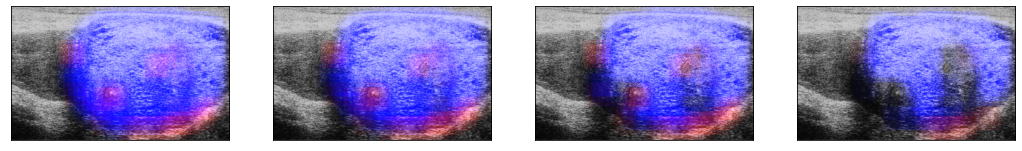

In [33]:
thr_list = [.7,.8,.85,.9]
bmodes = []
for thr in thr_list:
    out_bmode = plot_heatmap(bmode, prstt_mask, predictions, uncertainty, patch_centers, pred_transp=0.05, bmode_transp=.8,
                 conf_thr=thr)
    bmodes.append(out_bmode)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 12))
ax0.imshow(bmodes[0],norm=NoNorm())
ax1.imshow(bmodes[1],norm=NoNorm())
ax2.imshow(bmodes[2],norm=NoNorm())
ax3.imshow(bmodes[3],norm=NoNorm())

for ax_ in [ax0,ax1,ax2,ax3]:
     ax_.axes.xaxis.set_ticks([])
     ax_.axes.yaxis.set_ticks([])
plt.show()

In [60]:
# needle = mpimg.imread('../needle.png')

# needle = rearrange(needle, 'h w c -> c h w')
# # needle = (needle - np.mean(needle, axis=(0,1)))
# plt.imshow(needle, norm=NoNorm())
# plt.show()
#
# img = x_data[0,...]
# img = rearrange(img, 'c h w -> h w c')
#
# img_label = y_label[0,...]
# img_prediction = predictions[0,...]
#
#
# plt.imshow(img,cmap='gray',norm=NoNorm())
# plt.show()

In [ ]:
needle = mpimg.imread('../needle.png')
core_cumsum = np.cumsum(core_len)
indx, = np.where(patient_id_bk==36)
for j in indx:
    print('Patient:', int(patient_id_bk[j]), 'Inv:', true_involvement[j], f'Pred:{predicted_involvement[j]:.3}')
    start = 0 if j==0 else core_cumsum[j-1]
    end = core_cumsum[j]
    pred_colormap(needle, x_data[start:end,...], predictions[start:end,...],
                  patient_id_bk[j], true_involvement[j], predicted_involvement[j], gs_bk[j])